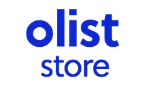

<h1><center> NOTEBOOK D'ESSAIS

# SOMMAIRE  <a id="0"></a>

I.  [Importation des bibliothèques et données, preprocessing](#1)<br>
II. [Clustering hiérarchique](#2)<br>
III. [Kmeans](#3)<br>
IV. [Dbscan](#4)<br>

# I. Importation des bibliothèques et données  <a id="1"></a>

In [2]:
#import necessary libraries
import pandas as pd
import numpy as np
from itertools import product #efficient looping
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import plotly.express as px

#librairies for preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import RobustScaler
from sklearn.compose import make_column_transformer

#librairies for hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

#librairies for k_means
from sklearn.cluster import KMeans

#librairies for DBSCAN
from sklearn.cluster import DBSCAN

#librairies evaluation
from sklearn import metrics
from yellowbrick.cluster import silhouette_visualizer,KElbowVisualizer

from time import time
from sklearn.decomposition import PCA

In [3]:
#import file
customers=pd.read_csv('clients.csv')

In [4]:
customers.head()

customer_unique_id  nb_orders  mean_spent_per_order  \
0  0000366f3b9a7992bf8c76cfdf3221e2          1                141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1                 27.19   
2  0000f46a3911fa3c0805444483337064          1                 86.22   
3  0000f6ccb0745a6a4b88665a16c9f078          1                 43.62   
4  0004aac84e0df4da2b147fca70cf8255          1                196.89   

   mean_items_per_order  mean_unique_cat_per_order  num_review_comments  \
0                   1.0                        1.0                    1   
1                   1.0                        1.0                    0   
2                   1.0                        1.0                    0   
3                   1.0                        1.0                    1   
4                   1.0                        1.0                    0   

   mean_score  recency  age  year  SP  
0         5.0      160  160  2018   1  
1         4.0      163  163  2018   1  
2         3.0      585  585  2017   0  
3         4.0      369  369  2017   0  
4         5.0      336  336  2017   1

In [5]:
#récupérons les features
customers_features=customers.drop(columns=['customer_unique_id','age','year','SP'])

In [6]:
scaler=RobustScaler(unit_variance=True)

In [7]:
#scaling
customers_scaled=scaler.fit_transform(customers_features)

In [7]:
customers_scaled.shape

(96096, 7)

# II. Clustering Hiérarchique <a id="2"></a>

Nous n'avons pas pu effectuer la segmentation sur l'ensemble de la population, nous sélectionnons donc un échantillon

In [70]:
sample=customers_scaled[np.random.choice(customers_scaled.shape[0],50000, replace=False)]

In [71]:
%%time
# modelisation, le calcul des distances est obligatoire pour la visualisation

clustering = AgglomerativeClustering(n_clusters=None,distance_threshold=0, compute_distances=True).fit(sample)

Wall time: 4min 18s


In [73]:
# Fonction permettant créer le dendrogramme

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

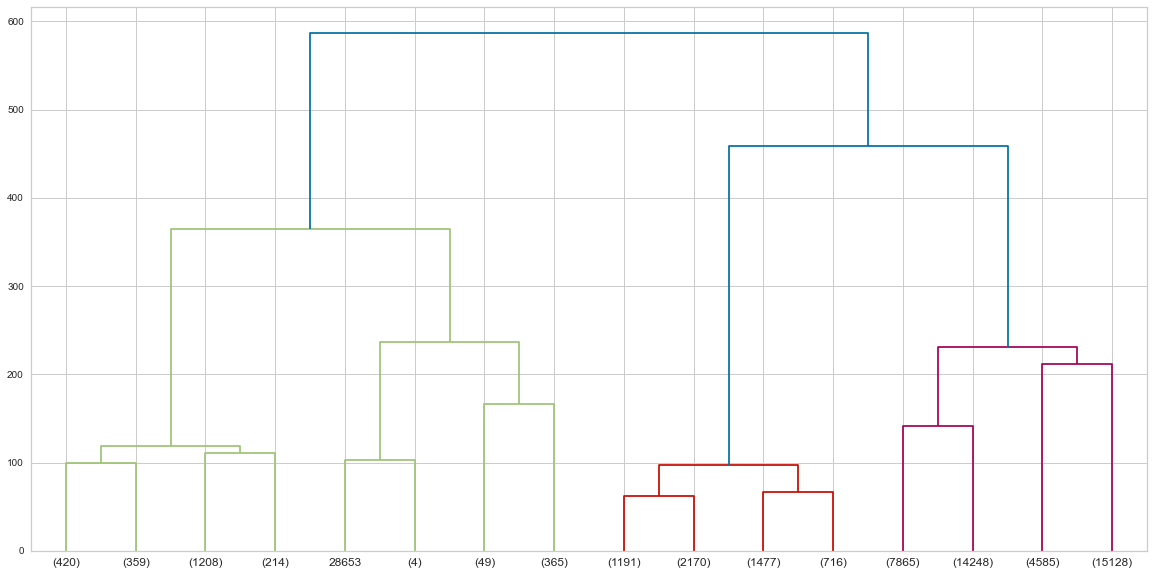

In [75]:
#visualisation du dendrogramme
fig, ax=plt.subplots(figsize=(20,10))
plot_dendrogram(clustering, truncate_mode="level", p=3)

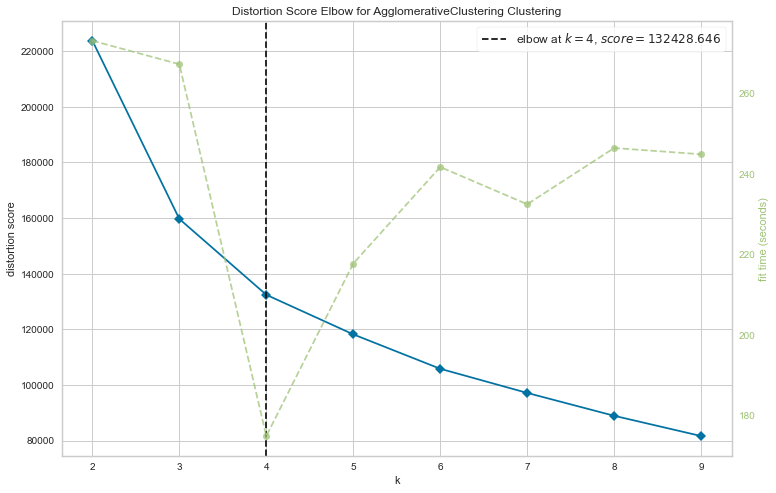

Wall time: 31min 39s


In [17]:
%%time
#calculating distortion_scores and fit_times for k clusters
fig, ax1 = plt.subplots(figsize=(12,8))

# Instantiate the clustering model and visualizer
model = AgglomerativeClustering()

visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion',ax=ax1)

visualizer.fit(sample)        # Fit the data to the visualizer
visualizer.show()

plt.show()

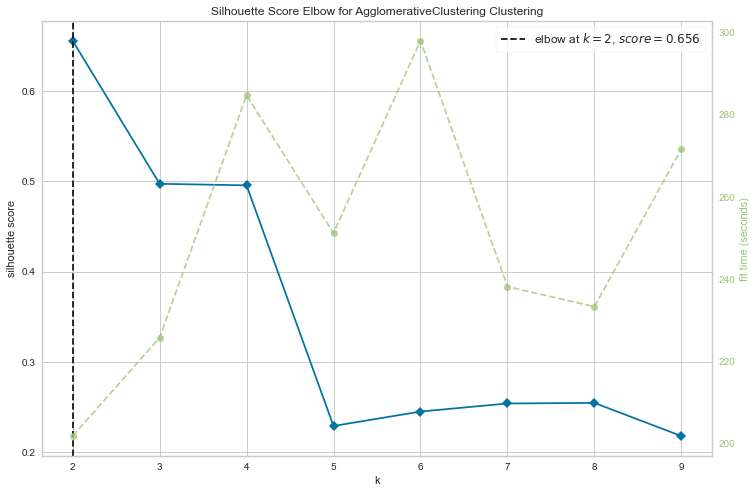

Wall time: 36min 25s


In [18]:
%%time
#calculating silhouette_scores and fit_times for k clusters
fig, ax1 = plt.subplots(figsize=(12,8))

# Instantiate the clustering model and visualizer
model = AgglomerativeClustering()

visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette',ax=ax1)

visualizer.fit(sample)        # Fit the data to the visualizer
visualizer.show()

plt.show()

# III. K-means <a id="3"></a>

## Recherche du nombre de clusters

Evaluons le nombre optimal de clusters en fonction de :
- la variace intra-cluster
- le coefficient de silhouette

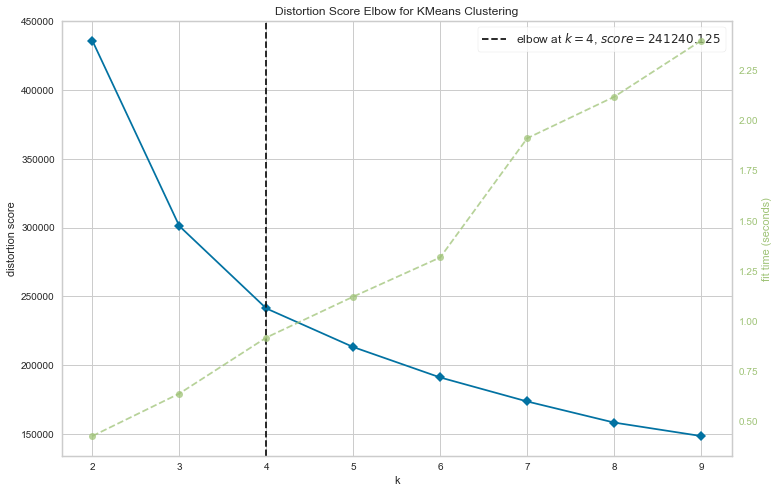

Wall time: 11.5 s


In [8]:
%%time
#calculating distortion_scores and fit_times for k clusters
fig, ax1 = plt.subplots(figsize=(12,8))

# Instantiate the clustering model and visualizer
model = KMeans(init="k-means++")

visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion',ax=ax1)

visualizer.fit(customers_scaled)        # Fit the data to the visualizer
visualizer.show()

plt.show()

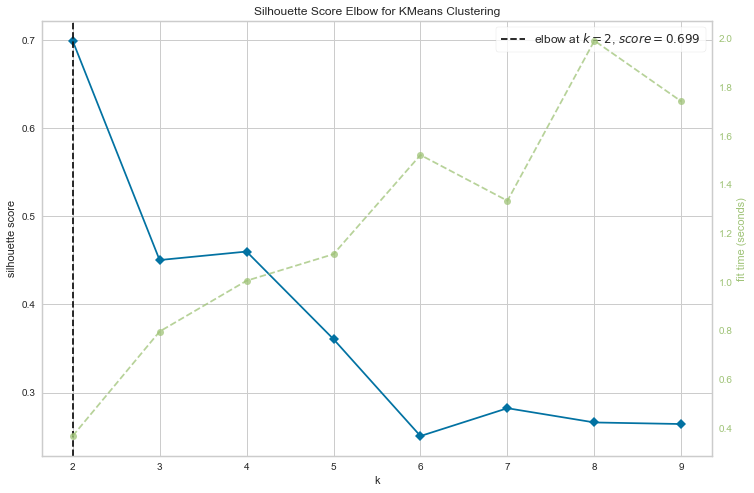

Wall time: 9min 48s


In [9]:
%%time
#calculating silhouette_scores and fit_times for k clusters
fig, ax1 = plt.subplots(figsize=(12,8))

# Instantiate the clustering model and visualizer
model = KMeans(init="k-means++")

visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette',ax=ax1)

visualizer.fit(customers_scaled)        # Fit the data to the visualizer
visualizer.show()

plt.show()

## Analysons la densité des clusters

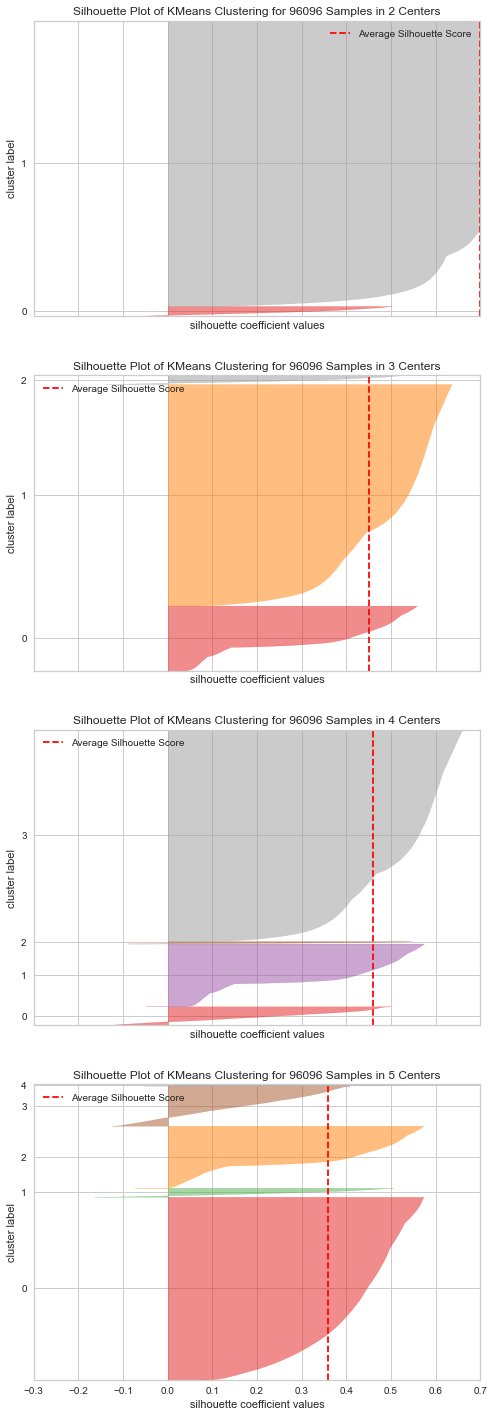

Wall time: 10min 35s


In [10]:
%%time

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(8,25), sharex=True)
klusters = [2,3,4,5]

for k, ax in zip(klusters,[ax1,ax2,ax3,ax4]):
    model=KMeans(k, init="k-means++" )
    silhouette_visualizer(model,customers_scaled, ax=ax, show=False)
    
plt.show()

## Analyse des clusters

In [8]:
%%time
kmeans=KMeans(4, init="k-means++" )
kmeans.fit(customers_scaled)

Wall time: 1.09 s


KMeans(n_clusters=4)

Analysons les centroïdes

In [9]:
centroides=scaler.inverse_transform(kmeans.cluster_centers_)

In [10]:
#creation d'un dataframe avec les coordonnées des centroïdes
centroides_df=pd.DataFrame(centroides)
centroides_df.columns=customers_features.columns

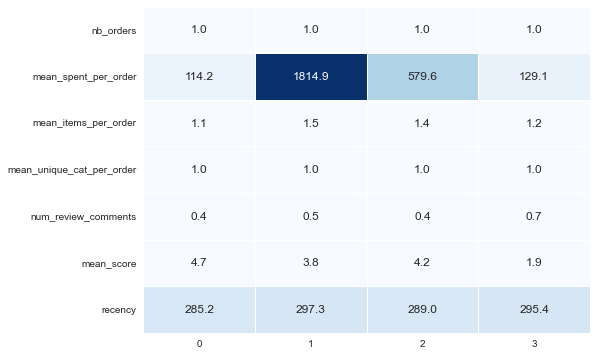

In [11]:
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(centroides_df.T, annot=True, linewidths=.5, ax=ax, fmt='.1f', cbar=False, cmap='Blues')
plt.show()

In [12]:
#ajoutons une colonne avec le numéro de cluster
customers_features['Cluster']=kmeans.labels_.astype('object')

In [13]:
customers_features['Cluster'].value_counts()

0    68709
3    20429
2     6163
1      795
Name: Cluster, dtype: int64

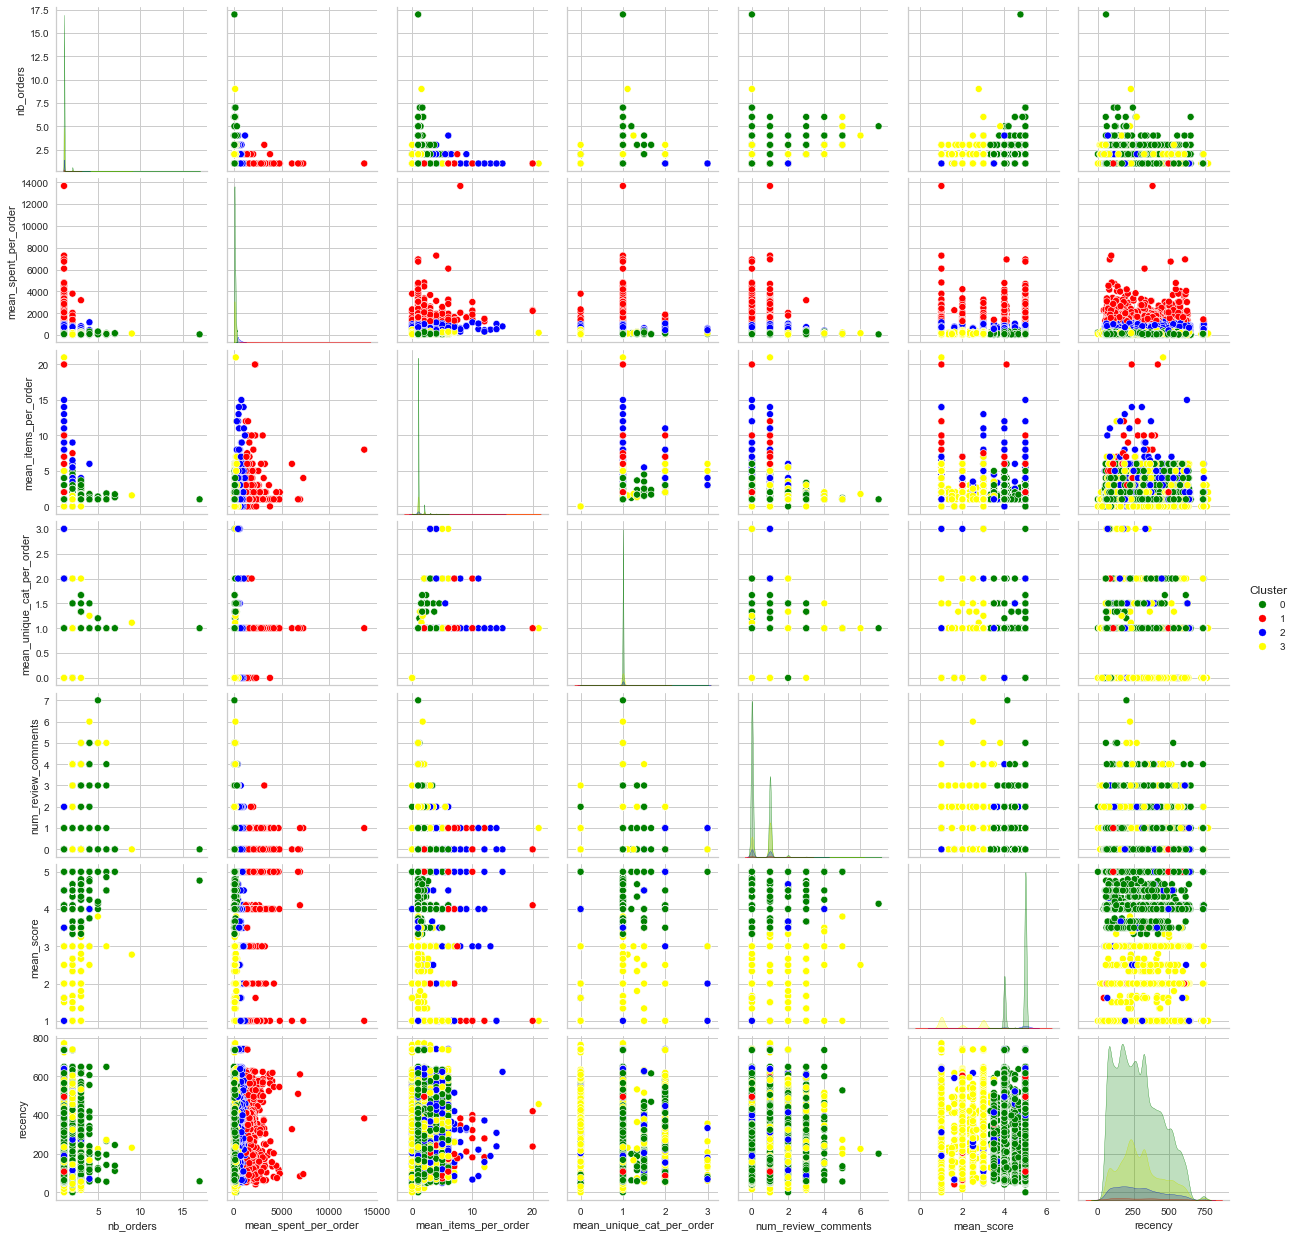

In [14]:
sns.pairplot(data=customers_features,hue='Cluster', palette=['green', 'red','blue','yellow'])

# IV. DBSCAN <a id="4"></a>

Créons une grille de paramètres que nous allons tester.
Pour chaque combinaison de paramètres nous allons comparer le nombre de cluster et le coefficient de silhouette créés par DBSCAN

In [8]:
epsilons = np.arange(0.25,2,0.25)
min_samples=np.arange(100,400,100)

dbscan_params = list(product(epsilons, min_samples))

In [9]:
len(dbscan_params)

21

In [10]:
%%time
num_clusters=[]
silhouette_scores=[]

for p in dbscan_params:
    dbscan = DBSCAN(eps=p[0], min_samples=p[1]).fit(customers_scaled)
    
    silhouette=metrics.silhouette_score(
        customers_scaled,
        dbscan.labels_,
        metric='euclidean',
        )
    
    num_clusters.append(len(set(dbscan.labels_)))
    silhouette_scores.append(silhouette)

Wall time: 1h 5min 20s


In [11]:
data=pd.DataFrame.from_dict({'num_clusters':num_clusters,'silhouette_scores':silhouette_scores, 'dbscan_params':dbscan_params})

In [12]:
data

num_clusters  silhouette_scores dbscan_params
0             10           0.085791   (0.25, 100)
1              9           0.006112   (0.25, 200)
2              5          -0.025985   (0.25, 300)
3             16           0.117266    (0.5, 100)
4             11           0.121503    (0.5, 200)
5             10           0.113085    (0.5, 300)
6             11          -0.090967   (0.75, 100)
7             10          -0.117929   (0.75, 200)
8              8           0.050193   (0.75, 300)
9             17          -0.104009    (1.0, 100)
10             9          -0.081711    (1.0, 200)
11             9          -0.095756    (1.0, 300)
12            18          -0.064002   (1.25, 100)
13            10          -0.040846   (1.25, 200)
14             8          -0.047068   (1.25, 300)
15             3           0.334741    (1.5, 100)
16             3           0.344799    (1.5, 200)
17             2           0.634407    (1.5, 300)
18             3           0.324505   (1.75, 100)
19             3           0.337536   (1.75, 200)
20             3           0.343284   (1.75, 300)

In [13]:
fig = px.scatter(data,x='num_clusters', y='silhouette_scores', hover_data=['dbscan_params']
                )
fig.show('notebook')